# FIFA球员数据爬取及数据分析
Author: 张舟  
Student id: 18307110139

- 选题原因：由于本人对于足球比较感兴趣，对于FIFA这款足球游戏也接触多年，因此本次作业选择FIFA球员的数据集进行分析。

## Import packages and settings

In [1]:
# import packages and settings
import re
import requests
import parsel
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
from bs4 import BeautifulSoup
from matplotlib.pyplot import MultipleLocator
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
plt.rcParams['font.sans-serif'] = ['Heiti TC']   #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False   #用来正常显示负号
sns.set_theme(style="ticks")
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## 数据爬取

- 本爬虫爬取的数据集来自 *https://sofifa.com/* ，一个由网友制作的FIFA球员数据库网站。
- 爬虫代码框架取自 *https://github.com/GitSujal/crawlerforfifaData* ，该爬虫框架是github上的开源项目，创建于3年前，目前由于网站更新改版已经无法正常运行。我使用Beautiful Soup 4包<font color=#FF000 >修改</font>了basic player information部分的代码，用parsel包<font color=#FF000 >重写</font>了detailed player information部分，使得代码能够正确运行，获得球员的各项数据。  

\* *由于代码运行时间较长，以下基础信息仅爬取2页球员数据，详细信息仅爬取10个球员作为示例*

### Get basic player information for all players

In [3]:
# 初始值设置
base_url = "https://sofifa.com/players?col=oa&sort=desc&offset="
columns = ['ID', 'Name', 'Age', 'Photo', 'Nationality', 'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Total']
data = pd.DataFrame(columns = columns)

# 爬虫主体
for offset in range(0, 2):  ## 此处循环次数表示爬取的页数，每一页中有60个球员，本数据集的基础信息爬起了278页
    url = base_url + str(offset * 60)
    source_code = requests.get(url)
    plain_text = source_code.text
    soup = BeautifulSoup(plain_text, 'html.parser')
    table_body = soup.find('tbody')
    for row in table_body.findAll('tr'):
        td = row.findAll('td')
        picture = td[0].find('img').get('data-src')
        pid = td[0].find('img').get('id')
        nationality = td[1].find('img').get('title')
        name = td[1].findAll('div')[0].text
        age = td[2].text.strip()
        overall = td[3].text.strip()
        potential = td[4].text.strip()
        club = td[5].find('a').text
        club_logo = td[5].find('img').get('data-src')
        value = td[6].text.strip()
        wage = td[7].text.strip()
        total = td[8].text.strip()
        player_data = pd.DataFrame([[pid, name, age, picture, nationality, overall, potential, club, club_logo, value, wage, total]])
        player_data.columns = columns
        data = data.append(player_data, ignore_index=True)
data = data.drop_duplicates()
data.ID = data.ID.astype('int')

In [3]:
data

,ID,Name,Age,Photo,Nationality,Overall,Potential,Club,Club Logo,Value,Wage,Total
0,188545,R. Lewandowski,32,https://cdn.sofifa.net/players/188/545/22_60.png,Poland,92,92,FC Bayern München,https://cdn.sofifa.net/teams/21/30.png,€119.5M,€270K,2211
1,158023,L. Messi,34,https://cdn.sofifa.net/players/158/023/22_60.png,Argentina,92,92,Paris Saint-Germain,https://cdn.sofifa.net/teams/73/30.png,€69.5M,€290K,2206
2,231747,K. Mbappé,22,https://cdn.sofifa.net/players/231/747/22_60.png,France,91,95,Paris Saint-Germain,https://cdn.sofifa.net/teams/73/30.png,€194M,€230K,2175
3,209331,M. Salah,29,https://cdn.sofifa.net/players/209/331/22_60.png,Egypt,91,91,Liverpool,https://cdn.sofifa.net/teams/9/30.png,€129M,€350K,2236
4,192985,K. De Bruyne,30,https://cdn.sofifa.net/players/192/985/22_60.png,Belgium,91,91,Manchester City,https://cdn.sofifa.net/teams/10/30.png,€125.5M,€350K,2303
...,...,...,...,...,...,...,...,...,...,...,...,...
115,206517,J. Grealish,25,https://cdn.sofifa.net/players/206/517/22_60.png,England,84,85,Manchester City,https://cdn.sofifa.net/teams/10/30.png,€50.5M,€180K,2018
116,204963,Carvajal,29,https://cdn.sofifa.net/players/204/963/22_60.png,Spain,84,84,Real Madrid CF,https://cdn.sofifa.net/teams/243/30.png,€37M,€195K,2103
117,204639,S. Savić,30,https://cdn.sofifa.net/players/204/639/22_60.png,Montenegro,84,84,Atlético de Madrid,https://cdn.sofifa.net/teams/240/30.png,€34.5M,€74K,1735
118,202811,E. Martínez,28,https://cdn.sofifa.net/players/202/811/22_60.png,Argentina,84,84,Aston Villa,https://cdn.sofifa.net/teams/2/30.png,€30M,€81K,1449


In [4]:
# 输出为文件
# data.to_csv('FIFA_player_basic_data.csv', encoding='utf-8-sig')

### Get detailed player information from player page

In [5]:
# 基础信息数据读取（此处为示例因此不需要读取）
# data = pd.read_csv('FIFA_player_basic_data.csv', encoding='utf-8-sig')
# data_finished = pd.read_csv('FIFA_player_data_backup.csv', encoding='utf-8-sig')
# data_cut = data_finished[~data_finished['Preferred Foot'].isna()]
# data_todo = data[data_finished['Preferred Foot'].isna()]

In [4]:
# 初始值设置
warnings.filterwarnings("ignore")
detailed_columns = ['Preferred Foot', 'Weak Foot', 'Skill Moves', 'International Reputation', 'Work Rate', 'Body Type', 'Real Face', 'Release Clause', 'ID', 'Position', 
                    'Specialities', 
                    'Height', 'Weight', 
                    'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'GK', 
                    'Crossing', 'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys', 'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control', 'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'Long Shots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Defensive Awareness', 'Standing Tackle', 'Sliding Tackle', 'GK Diving', 'GK Handling', 'GK Kicking', 'GKPositioning', 'GK Reflexes']
detailed_data = pd.DataFrame(index = range(0, data.count()[0]), columns = detailed_columns)
detailed_data.ID = data.ID.values
player_data_url = 'HTTPS://sofifa.com/player/'

# 爬虫主体
for id in data.ID[:10]:
    url = player_data_url + str(id) + '/220054/'  # 220054表示22年最新一版数据
    source_code = requests.get(url, verify=False)
    plain_text = source_code.text
    selector = parsel.Selector(plain_text)
    skill_map = {}
    
    # col 0-9
    lst1 = selector.css('.pl .ellipsis ::text').getall()
    var1 = selector.css('.pl .ellipsis >label::text').getall()
    value1 = [i for i in lst1 if (i not in var1 and i != ' ' and i[0] != '#')]
    if len(value1) == 11:
        for i in range(10):
            skill_map[detailed_columns[i]] = value1[i]
    else:
        detailed_columns_temp = detailed_columns.copy()
        detailed_columns_temp.remove('Release Clause')
        for i in range(9):
            skill_map[detailed_columns_temp[i]] = value1[i]
    skill_map['ID'] = int(skill_map['ID'])
    
    # col 10
    if any([re.findall('#.+',i) != [] for i in lst1]):
        skill_map['Specialities'] = ','.join([re.findall('#.+',i)[0][1:] for i in lst1 if re.findall('#.+',i) != []])
    
    # col 11,12
    lst2 = selector.css('.info .meta.ellipsis ::text').getall()
    value2 = lst2[-1].split()[-2:]
    skill_map['Height'] = value2[0]
    skill_map['Weight'] = value2[1]
    
    # col 13-39
    lst3 = selector.css('.col-4 .bp3-tag ::text').getall()
    value3 = lst3[1:54:2]
    for i in range(13,40):
        skill_map[detailed_columns[i]] = value3[i-13]
    
    # col 40-73
    lst4 = selector.css('.col-12 .bp3-tag ::text').getall()
    value4 = lst4[-34:]
    for i in range(40,74):
        skill_map[detailed_columns[i]] = value4[i-40]
    
    for key, value in skill_map.items():
        detailed_data.loc[detailed_data.ID == id, key] = value


In [7]:
full_data = pd.merge(data, detailed_data, how = 'inner', on = 'ID')
full_data.head(10)

,ID,Name,Age,Photo,Nationality,Overall,Potential,Club,Club Logo,Value,...,Penalties,Composure,Defensive Awareness,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GKPositioning,GK Reflexes
0,188545,R. Lewandowski,32,https://cdn.sofifa.net/players/188/545/22_60.png,Poland,92,92,FC Bayern München,https://cdn.sofifa.net/teams/21/30.png,€119.5M,...,90,88,35,42,19,15,6,12,8,10
1,158023,L. Messi,34,https://cdn.sofifa.net/players/158/023/22_60.png,Argentina,92,92,Paris Saint-Germain,https://cdn.sofifa.net/teams/73/30.png,€69.5M,...,75,96,20,35,24,6,11,15,14,8
2,231747,K. Mbappé,22,https://cdn.sofifa.net/players/231/747/22_60.png,France,91,95,Paris Saint-Germain,https://cdn.sofifa.net/teams/73/30.png,€194M,...,79,88,26,34,32,13,5,7,11,6
3,209331,M. Salah,29,https://cdn.sofifa.net/players/209/331/22_60.png,Egypt,91,91,Liverpool,https://cdn.sofifa.net/teams/9/30.png,€129M,...,86,92,38,43,41,14,14,9,11,14
4,192985,K. De Bruyne,30,https://cdn.sofifa.net/players/192/985/22_60.png,Belgium,91,91,Manchester City,https://cdn.sofifa.net/teams/10/30.png,€125.5M,...,83,89,68,65,53,15,13,5,10,13
5,165153,K. Benzema,33,https://cdn.sofifa.net/players/165/153/22_60.png,France,91,91,Real Madrid CF,https://cdn.sofifa.net/teams/243/30.png,€84M,...,84,90,43,24,18,13,11,5,5,7
6,20801,Cristiano Ronaldo,36,https://cdn.sofifa.net/players/020/801/22_60.png,Portugal,91,91,Manchester United,https://cdn.sofifa.net/teams/11/30.png,€45M,...,90,95,24,32,24,7,11,15,14,11
7,215914,N. Kanté,30,https://cdn.sofifa.net/players/215/914/22_60.png,France,90,90,Chelsea,https://cdn.sofifa.net/teams/5/30.png,€100M,...,54,84,90,93,86,15,12,10,7,10
8,203376,V. van Dijk,29,https://cdn.sofifa.net/players/203/376/22_60.png,Netherlands,90,90,Liverpool,https://cdn.sofifa.net/teams/9/30.png,€100M,...,62,90,92,92,86,13,10,13,11,11
9,190871,Neymar Jr,29,https://cdn.sofifa.net/players/190/871/22_60.png,Brazil,90,90,Paris Saint-Germain,https://cdn.sofifa.net/teams/73/30.png,€117.5M,...,91,93,35,32,29,9,9,15,15,11


In [8]:
# 与基础信息文件合并并输出
# out_data = pd.merge(data_todo, detailed_data, how = 'inner', on = 'ID')
# full_data = data_cut.append(out_data).iloc[:,1:].reset_index(drop = True)
# full_data.to_csv('FIFA_player_data.csv', encoding='utf-8-sig')

## 球员数据分析

由于代码运行效率不是很高，因此我爬取了不到10000条球员数据进行分析，具体数据如下所示：

In [6]:
dt_22 = pd.read_csv('Dataset/FIFA_player_data_v1.csv', encoding = 'utf-8-sig')
dt_22 = dt_22[~dt_22['Preferred Foot'].isna()]
dt_22

/Users/a10257/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,ID,Name,Age,Photo,Nationality,Overall,Potential,Club,Club Logo,...,Penalties,Composure,Defensive Awareness,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GKPositioning,GK Reflexes
0,0,188545,R. Lewandowski,32,https://cdn.sofifa.net/players/188/545/22_60.png,Poland,92,92,FC Bayern München,https://cdn.sofifa.net/teams/21/30.png,...,90.0,88.0,35.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0
1,1,158023,L. Messi,34,https://cdn.sofifa.net/players/158/023/22_60.png,Argentina,92,92,Paris Saint-Germain,https://cdn.sofifa.net/teams/73/30.png,...,75.0,96.0,20.0,35.0,24.0,6.0,11.0,15.0,14.0,8.0
2,2,231747,K. Mbappé,22,https://cdn.sofifa.net/players/231/747/22_60.png,France,91,95,Paris Saint-Germain,https://cdn.sofifa.net/teams/73/30.png,...,79.0,88.0,26.0,34.0,32.0,13.0,5.0,7.0,11.0,6.0
3,3,209331,M. Salah,29,https://cdn.sofifa.net/players/209/331/22_60.png,Egypt,91,91,Liverpool,https://cdn.sofifa.net/teams/9/30.png,...,86.0,92.0,38.0,43.0,41.0,14.0,14.0,9.0,11.0,14.0
4,4,192985,K. De Bruyne,30,https://cdn.sofifa.net/players/192/985/22_60.png,Belgium,91,91,Manchester City,https://cdn.sofifa.net/teams/10/30.png,...,83.0,89.0,68.0,65.0,53.0,15.0,13.0,5.0,10.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156,9156,205158,Guillermo,28,https://cdn.sofifa.net/players/205/158/22_60.png,Spain,66,66,Burgos CF,https://cdn.sofifa.net/teams/10846/30.png,...,74.0,64.0,33.0,29.0,27.0,9.0,10.0,7.0,7.0,9.0
9157,9157,209510,A. Corryn,27,https://cdn.sofifa.net/players/209/510/22_60.png,Belgium,66,66,KSV Cercle Brugge,https://cdn.sofifa.net/teams/1750/30.png,...,35.0,68.0,67.0,65.0,62.0,16.0,6.0,6.0,9.0,14.0
9158,9158,177766,G. Bong,33,https://cdn.sofifa.net/players/177/766/22_60.png,Cameroon,66,66,Nottingham Forest,https://cdn.sofifa.net/teams/14/30.png,...,40.0,68.0,65.0,71.0,69.0,13.0,12.0,10.0,8.0,14.0
9159,9159,255590,T. Seko,23,https://cdn.sofifa.net/players/255/590/22_60.png,Japan,66,71,Kawasaki Frontale,https://cdn.sofifa.net/teams/111730/30.png,...,32.0,62.0,64.0,66.0,61.0,14.0,12.0,6.0,11.0,5.0


本数据集包含9161个球员的85个属性，主要可以分为以下几类：  

|  属性类型   | 内容  |
| :---- | :---- |
| 基本信息  | 姓名、年龄、头像、头像链接、国籍、俱乐部、俱乐部图标链接、国际声望 |
| 财务信息  | 工资、身价、解约金 |
| 总体评价  | 当前能力、潜在能力 |
| 位置  | 最佳位置、能踢的位置、各位置评分 |
| 足球能力  | 各项足球能力、专长 |
| 其它能力  | 身高、体重、体型、工作投入度 |

### 数据预处理

首先我们对数据进行一些处理
- 为了后面的分析，我还从别处找到了球员的位置信息融合进数据集中（前面的爬虫部分只获取了最佳位置）
- 重命名原来的Position列为Best Position
- 删除不需要的列
- 计算球员的位置评分并转换为数值型
- 去除缺失值
- 将球员的身价、工资、身高等字符型转化为数值型，便于后续分析

以下进行处理并展示部分处理结果：

In [7]:
dt_22 = dt_22.drop(columns=['Total','Real Face','Unnamed: 0'])
dt_supplement = pd.read_csv('./Dataset/players_fifa22.csv')
df1 = dt_22[['Value','Wage','Release Clause','Height','Weight','LS']]

# 修改列名
dt_22.rename(columns={'Position':'Best Position'},inplace=True)

# 转换各种价格
def value_to_num(col):
    if pd.isnull(col): return 0
    
    value = col.replace('€', '').replace('M', '').replace('K', '')
    
    if col[-1] == 'M': unit = 1e6
    elif col[-1] == 'K': unit = 1e3
    else: unit = 1
    
    return float(value)*unit

dt_22.Value = dt_22.Value.apply(value_to_num)
dt_22.Wage = dt_22.Wage.apply(value_to_num)
dt_22['Release Clause'] = dt_22['Release Clause'].apply(value_to_num)

# 转换身高体重
dt_22.Height = pd.to_numeric(dt_22.Height.str[:-2])
dt_22.Weight = pd.to_numeric(dt_22.Weight.str[:-2])

# 转换位置评分
for i in range(22,49):
    dt_22.iloc[:,i] = dt_22.iloc[:,i].str.split('+').map(lambda x:int(x[0])+int(x[1]))

# merge位置信息
dt_22 = pd.merge(dt_22,dt_supplement.iloc[:,[0,13]],how='left',on='ID')
dt_22 = dt_22[~dt_22.Positions.isna()]

df2 = dt_22[['Value','Wage','Release Clause','Height','Weight','LS']]

display('df1','df2')

,Value,Wage,Release Clause,Height,Weight,LS
0,€119.5M,€270K,€197.2M,185cm,81kg,90+2
1,€69.5M,€290K,€128.6M,169cm,67kg,88+3
2,€194M,€230K,€373.5M,182cm,73kg,89+3
3,€129M,€350K,€238.7M,175cm,71kg,86+3
4,€125.5M,€350K,€232.2M,181cm,70kg,83+3
...,...,...,...,...,...,...
9156,€875K,€3K,€1.4M,181cm,74kg,66+0
9157,€825K,€4K,€1.2M,177cm,73kg,51+2
9158,€450K,€12K,€855K,187cm,74kg,55+2
9159,€1.3M,€3K,€1.8M,175cm,69kg,57+2


In [8]:
dt_22.describe()

,ID,Age,Overall,Potential,Value,Wage,Weak Foot,Skill Moves,International Reputation,Release Clause,...,Penalties,Composure,Defensive Awareness,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GKPositioning,GK Reflexes
count,8619.000000,8619.000000,8619.000000,8619.000000,8.619000e+03,8619.000000,8619.000000,8619.000000,8619.000000,8.619000e+03,...,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000
mean,222704.950110,26.520014,71.476041,74.222764,5.511620e+06,16713.893723,3.060216,2.600650,1.189465,9.660481e+06,...,52.434041,65.407124,52.215338,53.087945,50.411533,16.199443,16.000580,15.861933,16.130294,16.348300
std,25265.908357,4.222453,4.308209,5.190011,1.077937e+07,26142.513525,0.698750,0.832408,0.512956,2.078727e+07,...,16.011046,9.791659,20.626001,21.909144,21.788257,18.230507,17.473379,17.041387,17.941347,18.660979
min,41.000000,16.000000,66.000000,66.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000e+00,...,8.000000,12.000000,5.000000,7.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,206535.000000,23.000000,68.000000,70.000000,1.300000e+06,4000.000000,3.000000,2.000000,1.000000,1.700000e+06,...,42.000000,60.000000,34.000000,33.000000,29.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,227873.000000,26.000000,71.000000,73.000000,2.100000e+06,8000.000000,3.000000,3.000000,1.000000,3.400000e+06,...,54.000000,66.000000,61.000000,64.000000,61.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,240476.000000,29.000000,74.000000,78.000000,4.400000e+06,19000.000000,3.000000,3.000000,1.000000,7.400000e+06,...,65.000000,72.000000,69.000000,70.000000,68.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,264473.000000,43.000000,92.000000,95.000000,1.940000e+08,450000.000000,5.000000,5.000000,5.000000,3.735000e+08,...,92.000000,96.000000,92.000000,93.000000,90.000000,90.000000,90.000000,93.000000,90.000000,90.000000


### 描述性统计与初步探索

#### 球员能力值相关系数热力图

由于此数据集中每个球员都有二十多项能力指标，指标的数量比较多，很多指标之间可能存在着相关性，因此我们通过绘制相关系数热力图来观察是否能得到一些洞见。

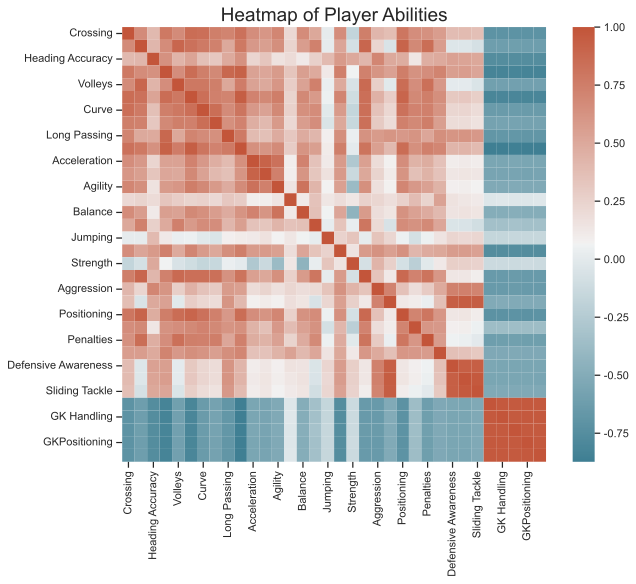

In [9]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
ax = sns.heatmap(dt_22.iloc[:,49:-1].corr(), cmap=cmap)
ax.set_title('Heatmap of Player Abilities',fontdict={'size':19})
ax.figure.set_size_inches(9.5,8)

**insights**
- 从上图中我们可以看出，右下角的变量存在着<font color=#FF000 >很强的正相关性</font>，且与其他指标几乎都不相关甚至是负相关。观察发现这些指标都是门将能力的指标，这也与现实中的情况比较符合,门将的其它指标往往远低于非门将球员。
- 除了门将相关的指标外，其他指标几乎都呈现出一些正相关性。从现实来看，往往顶级的球员需要在各项指标上都达标，如果有明显瘸腿的指标很难成为最顶尖的球员。
- 总体来看指标之间的相关性比较强，后续可以考虑采用<font color=#FF000 >主成分分析</font>来进行数据降维。

#### 不同位置的球员能力值箱线图

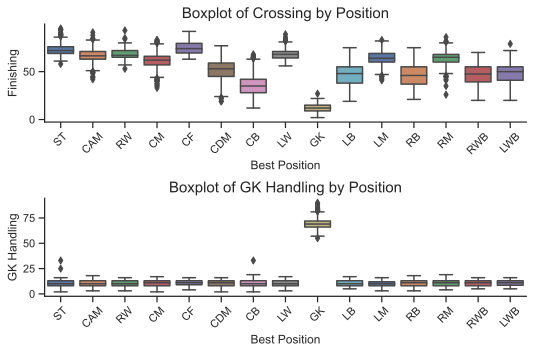

In [10]:
f=plt.figure(figsize=(15, 10))

f.add_subplot(2,1,1)

ax1 = sns.boxplot(x = 'Best Position', y = 'Finishing', data=dt_22, palette='deep') 
ax1.set_title('Boxplot of Crossing by Position',fontdict={'size':15})
ax1.figure.set_size_inches(7.5,5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)
sns.despine()

f.add_subplot(2,1,2)

ax2 = sns.boxplot(x = 'Best Position', y = 'GK Handling', data=dt_22, palette='deep')
ax2.set_title('Boxplot of GK Handling by Position',fontdict={'size':15})
ax2.figure.set_size_inches(7.5,5)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45)
sns.despine()

plt.tight_layout()

**Insights**
- 上面绘制了不同位置球员的终结（进球）能力和扑球不脱手能力的箱线图，结果与我们的预期相符，前场球员的终结能力更强，门将在门将相关的能力上显著高于其他人。
- 这里也间接说明了球员的位置与其能力值存在着一定的相关性，因此我们<font color=#FF000 >通过球员能力值来预测其最佳位置</font>是合理的。

#### 逆足水平与潜力相关性分析

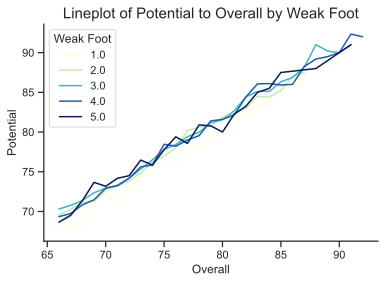

In [11]:
ax = sns.lineplot(x="Overall", y="Potential", hue="Weak Foot", data=dt_22, ci=0, palette='YlGnBu')
ax.set_title('Lineplot of Potential to Overall by Weak Foot',fontdict={'size':15})
sns.despine()

**Insights**
- 这里的结论<font color=#FF000 >出乎我的意料</font>，逆足在足球游戏的球员能力中一直是被讨论较多的指标，然而在相同评分的情况下，更高的逆足水平似乎并不会让球员被认为有更高的潜力值。


#### 惯用脚和边路选择问题

- 在足球这项运动中，有些球员惯用左脚，有些球员惯用右脚，不同的惯用脚往往预示着球员更适应在球场的某一侧活动，例如惯用右脚的球员在4-3-3阵型中可以出任左边锋，完成内切的任务，而惯用左脚的球员想要内切则只能选择在右边路。当然，由于足球战术的多样性，左脚球员在左路也可以完成类似下底传中的作用。
- 那么在左边路的不同位置对于惯用脚是否存在偏好呢？下面我们来研究这一问题。

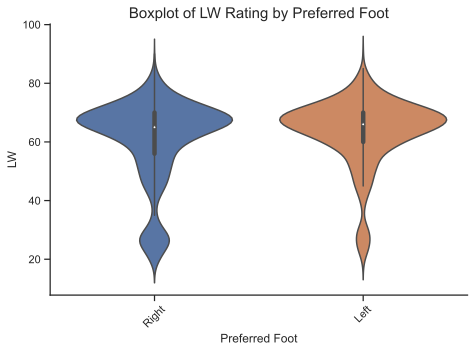

In [12]:
ax = sns.violinplot(x = 'Preferred Foot', y = 'LW', data=dt_22, palette='deep') 
ax.set_title('Boxplot of LW Rating by Preferred Foot',fontdict={'size':15})
ax.figure.set_size_inches(7.5,5)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
sns.despine()

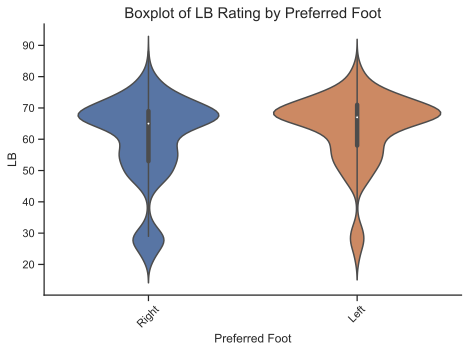

In [13]:
ax = sns.violinplot(x = 'Preferred Foot', y = 'LB', data=dt_22, palette='deep') 
ax.set_title('Boxplot of LB Rating by Preferred Foot',fontdict={'size':15})
ax.figure.set_size_inches(7.5,5)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
sns.despine()

**Insights**
- 从上面的第一张小提琴图我们可以发现，在高评分的左边锋球员中，左右脚球员的分布比较<font color=#FF000 >均衡</font>，但是低评分球员右脚居多。说明左边锋球员完成的功能比较多样，既可以直接威胁球门，又可以通过传球制造机会，<font color=#FF000 >不管是惯用哪只脚都可以成为出色的左边锋</font>。
- 从第二张小提琴图我们也可以得到类似的结论，但是区别在于左脚的左边后卫球员总评略高于右脚球员。这是因为左后卫在足球中很少直接威胁球门，更多的是通过<font color=#FF000 >传球制造机会</font>，因此左脚球员在这个位置上更有优势。（否则可能会被教练叫去踢左边锋）

### 基于PCA的球员能力值降维

在数据集中，球员的能力值有很多种，并且种类繁多比较难以理解，很多能力值之间存在着一定的相关性。因此我们考虑对球员的各项能力值做一个主成分分析，实现能力值数据的降维，更加直观的理解球员的各项能力值。

sklearn中有现成的包可以做主成分分析，此处我们将尝试手动进行主成分分析，<font color=#FF000 >并与调包求出的结果做一个对比</font>。

\* *由于数据本身都是0-100之间的数值，因此不需要进行中心标准化。*

#### 调用sklearn.decomposition.PCA实现主成分分析

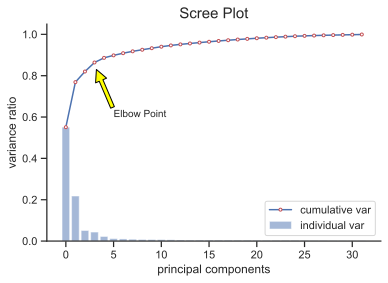

In [14]:
pca = PCA(n_components = 'mle')    # 自动选取特征数
pca.fit(dt_22.iloc[:,49:-2])     # 拟合模型
eigen_vec = pca.components_   # 返回模型各个特征向量
var_indi = pca.explained_variance_ratio_  # 各主成分占比（方差贡献率）
var_cumu = pd.Series(var_indi).expanding().sum()  # 累积主成分贡献率

# 碎石图
plt.bar(range(len(var_indi)), var_indi, alpha = 0.5, align = 'center', label = 'individual var')
plt.plot(range(len(var_indi)), var_cumu, label = 'cumulative var', marker = 'o', mec='r', mfc='w', ms = 3)
plt.ylabel('variance ratio')
plt.xlabel('principal components')
plt.legend(loc = 'best')
plt.title('Scree Plot',fontdict={'size':15})
plt.annotate('Elbow Point', xy=(3.2, 0.83), xytext=(5, 0.6), 
             arrowprops=dict(facecolor='yellow', edgecolor='black'), fontsize=10)
sns.despine()
plt.show()

根据上图，我们发现累计方差贡献率在选取4个主成分时已经接近0.9，并且斜率也出现了明显变化，因此我们选择4个主成分。

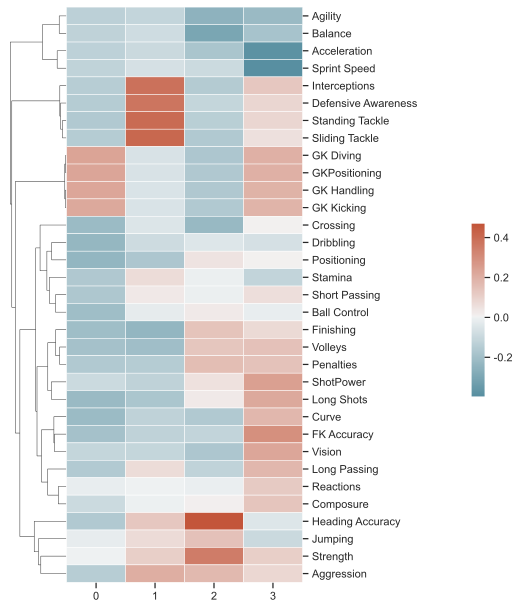

In [15]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
out = pd.DataFrame(eigen_vec[0:4]).T
out.index = dt_22.columns[49:-2]
ax = sns.clustermap(out, cmap=cmap, center=0, col_cluster=False, 
                    dendrogram_ratio=(.2, .3), cbar_pos=(1.1, .25, .03, .2), 
                   linewidths=.5, figsize=(6,12))
ax.ax_col_dendrogram.remove()

根据主成分特征向量的热力图我们可以简单对部分主成分进行描述：
- 第一个主成分可以认为是门将属性，它与门将的几个维度都呈现明显的正相关
- 第二个主成分可以认为是防守属性，它主要与一些防守技术以及身体力量，跳跃（高空球防守）呈现正相关  

后面的主成分解释性不是很强，说明前场球员的能力要求比较全面，因此我们这里不做解释。

下面绘制因子得分图，我们在两个主成分维度上绘制散点图，并以门将和防守属性为例分析PCA降维如何帮助我们快速识别某一类球员。

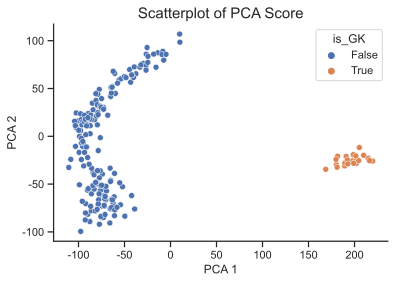

In [16]:
pca = PCA(4)  # 保留四个维度
score = pd.DataFrame(pca.fit_transform(dt_22.iloc[:,49:-2]))  # 计算因子得分
score['Best_Position'] = dt_22['Best Position']
score['is_GK'] = score['Best_Position'] == 'GK'
score['is_defender'] = score['Best_Position'].isin(['CB','LB','RB'])
score['Overall'] = dt_22['Overall']

ax = sns.scatterplot(x=score.iloc[:200,0],y=score.iloc[:200,1],hue='is_GK', data=score,legend='brief')
# ax.legend(loc=2, bbox_to_anchor=(1.05,0.6),borderaxespad = 0.)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('Scatterplot of PCA Score',fontdict={'size':15})
sns.despine()

我们可以发现门将球员在第一个维度上明显高于其他球员。因此通过计算球员的门将得分因子可以很容易的识别门将。

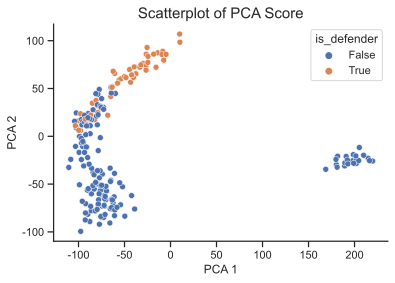

In [17]:
ax = sns.scatterplot(x=score.iloc[:200,0],y=score.iloc[:200,1],hue='is_defender', data=score,legend='brief')
# ax.legend(loc=2, bbox_to_anchor=(1.05,0.6),borderaxespad = 0.)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('Scatterplot of PCA Score',fontdict={'size':15})
sns.despine()

从上图我们同样可以看出，后卫（包含左后卫，中后卫和右后卫）类的球员在第二个因子得分上显著高于其它球员，因此我们也可以通过计算防守属性主成分来快速识别后卫球员。

#### 手动实现上述功能（附加内容）

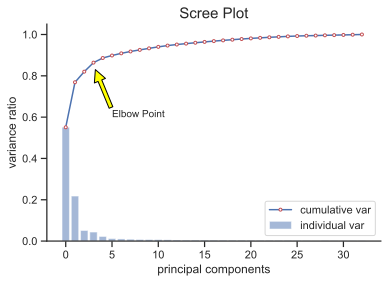

In [18]:
x = list(np.sqrt(np.var(dt_22.iloc[:,49:-2])))
varr = pd.DataFrame([x for i in range(33)])
rou = dt_22.iloc[:,49:-2].corr()
varr.index = rou.index
varr.columns = rou.columns
eig1,eig_vec1 = np.linalg.eig(varr * rou * varr.T)

var_ratio_indi = eig1/sum(eig1)
var_ratio_cumu = pd.Series(var_ratio_indi).expanding().sum()

# 碎石图
plt.bar(range(len(var_ratio_indi)), var_ratio_indi, alpha = 0.5, align = 'center', label = 'individual var')
plt.plot(range(len(var_ratio_indi)), var_ratio_cumu, label = 'cumulative var', marker = 'o', mec='r', mfc='w', ms = 3)
plt.ylabel('variance ratio')
plt.xlabel('principal components')
plt.legend(loc = 'best')
plt.title('Scree Plot',fontdict={'size':15})
plt.annotate('Elbow Point', xy=(3.2, 0.83), xytext=(5, 0.6), 
             arrowprops=dict(facecolor='yellow', edgecolor='black'), fontsize=10)
sns.despine()
plt.show()

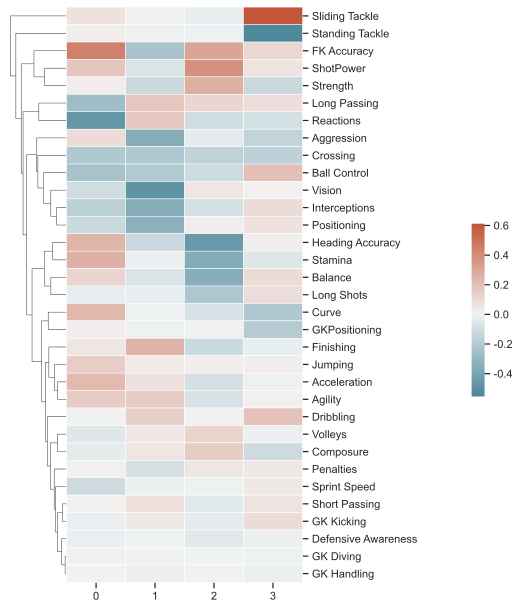

In [19]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
out = pd.DataFrame(eig_vec1[0:4]).T
out.index = dt_22.columns[49:-2]
ax = sns.clustermap(out, cmap=cmap, center=0, col_cluster=False, 
                    dendrogram_ratio=(.2, .3), cbar_pos=(1.1, .25, .03, .2), 
                   linewidths=.5, figsize=(6,12))
ax.ax_col_dendrogram.remove()

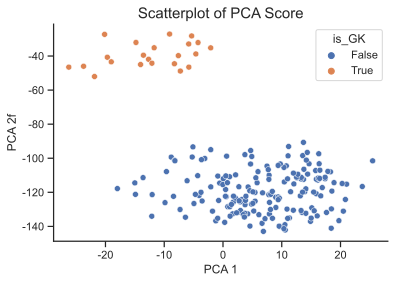

In [20]:
score1 = pd.DataFrame(np.dot(dt_22.iloc[:,49:-2], eig_vec1[0:4].T))  # 计算因子得分
score1['Best_Position'] = dt_22['Best Position']
score1['is_GK'] = score1['Best_Position'] == 'GK'
score1['Overall'] = dt_22['Overall']

ax = sns.scatterplot(x=score1.iloc[:200,0],y=score1.iloc[:200,1],hue='is_GK', data=score1,legend='brief')
# ax.legend(loc=2, bbox_to_anchor=(1.05,0.6),borderaxespad = 0.)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2f')
ax.set_title('Scatterplot of PCA Score',fontdict={'size':15})
sns.despine()

手动实现的主成分分析在累计方差贡献率上和调包得到的结果一样，但是每个主成分略有不同，猜测可能是sklearn的主成分分析对主成分矩阵进行了一定的变换使得主成分之间的相关性变得更小，这里因为时间关系不做进一步探究。

### 球员聚类分析

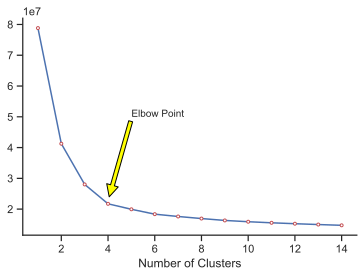

In [21]:
wcss = []

for k in range(1,15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dt_22.iloc[:,49:-2])
    wcss.append(kmeans.inertia_) # inertia means that find to value of wcss
    
plt.plot(range(1,15), wcss, marker = 'o', mec='r', mfc='w', ms = 3)
plt.xlabel('Number of Clusters')
plt.annotate('Elbow Point', xy=(4.05, 2.4e7), xytext=(5, 5e7), 
             arrowprops=dict(facecolor='yellow', edgecolor='black'), fontsize=10)
sns.despine()
plt.show()

根据inertias指标来看，聚4类时出现转折点，因此我们考虑聚类数量为4。

<IPython.core.display.Javascript object>


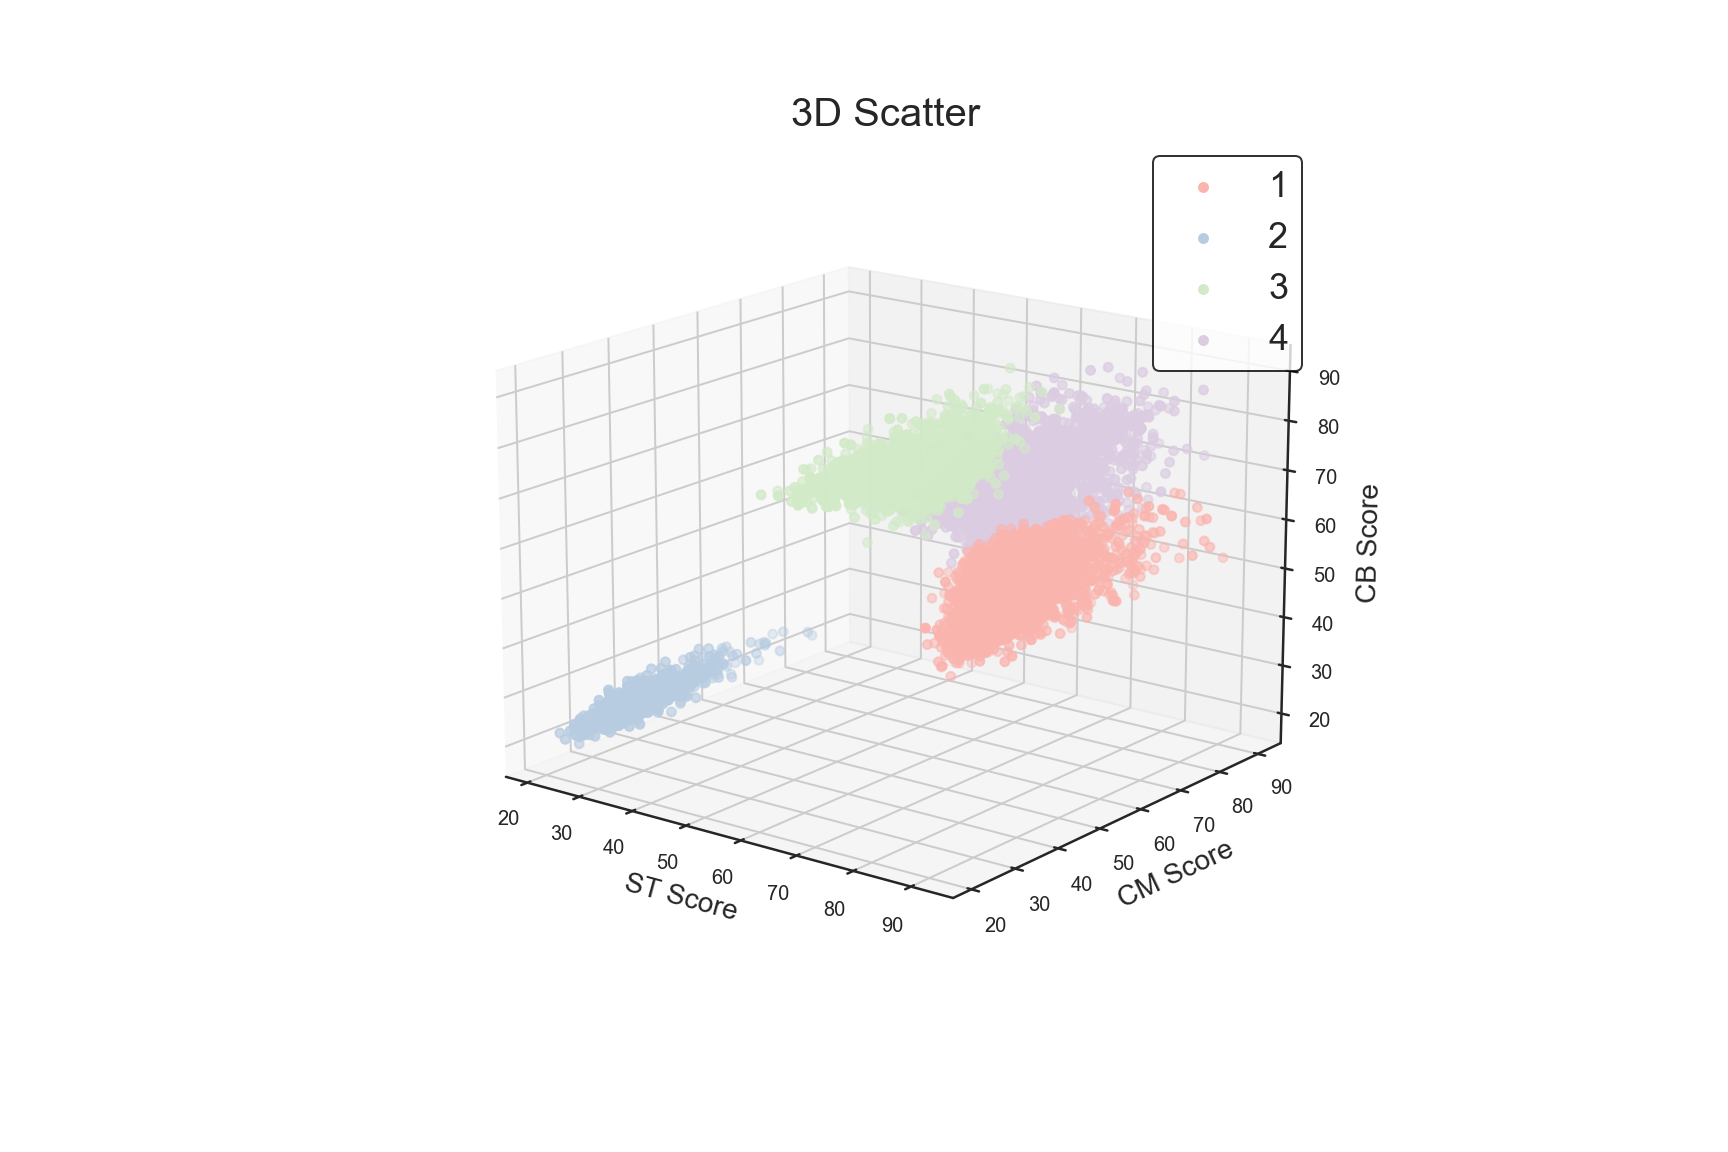

/var/folders/65/jgnz47dj6r99m1k93ry_wxwr0000gn/T/ipykernel_40267/338773939.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax3d = plt.gca(projection="3d")  # 创建三维坐标


In [22]:
kmean2 = KMeans(n_clusters=4)
clusters = kmean2.fit_predict(dt_22.iloc[:,49:-2])
dt_22['label'] = clusters

%matplotlib notebook
plt.figure("3D Scatter", facecolor="white",figsize=(12, 8))
ax3d = plt.gca(projection="3d")  # 创建三维坐标

plt.title('3D Scatter', fontsize=20)
ax3d.set_xlabel('ST Score', fontsize=14)
ax3d.set_ylabel('CM Score', fontsize=14)
ax3d.set_zlabel('CB Score', fontsize=14)
plt.tick_params(labelsize=10)

dt_221 = dt_22[dt_22.label == 0]
dt_222 = dt_22[dt_22.label == 1]
dt_223 = dt_22[dt_22.label == 2]
dt_224 = dt_22[dt_22.label == 3]

ax3d.scatter(dt_221['ST'], dt_221['CM'], dt_221['CB'], s=20, c='#FBB4AE', marker='o')
ax3d.scatter(dt_222['ST'], dt_222['CM'], dt_222['CB'], s=20, c='#B8CCE1', marker='o')
ax3d.scatter(dt_223['ST'], dt_223['CM'], dt_223['CB'], s=20, c='#D2EAC8', marker='o')
ax3d.scatter(dt_224['ST'], dt_224['CM'], dt_224['CB'], s=20, c='#DBCCE2', marker='o')

plt.legend([r"1",r"2",r"3",r"4"],fontsize=18,edgecolor="black",loc='best', frameon=True)

plt.show()

从上面的聚类我们可以看出：
- 第一类球员在前锋位置有较高的得分，后卫位置得分比较低，属于前场球员。
- 第二类球员在前锋、中场和后卫的得分都比较低，应该都是门将球员。
- 第三类球员在后卫位置得分比较高，属于后场球员。
- 第四类球员在中场位置得分比较高，属于中场球员。

总的来说聚类比较好的分开了各类球员，解释性也很不错。

聚类的结果说明球员的能力值基本还是按照不同的位置产生区别，个人认为这间接反映了足球运动专业化、分工化的趋势。上世纪的足球可能更会要求球员具有全面的能力，例如传奇球员贝肯鲍尔，里杰卡尔德等都兼具进攻和防守的能力，在现代足球中几乎见不到这样能力全面的球员了。

In [26]:
%matplotlib inline

### 通过线性回归分析球员能力值与中锋位置评分

首先我们对全数据集做一个线性回归，看看回归模型的拟合效果如何。

In [27]:
# 多元线性回归拟合
dt_22_ = dt_22.copy()
dt_22_.columns = dt_22.columns.str.replace(' ','_')
cols = list(dt_22_.columns)
formula = 'ST' + '~' + '+'.join(cols[49:-2])
r2 = smf.ols(formula, dt_22_).fit()
r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     ST   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.217e+05
Date:                Sat, 18 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:48:35   Log-Likelihood:                -7480.5
No. Observations:                8619   AIC:                         1.503e+04
Df Residuals:                    8584   BIC:                         1.528e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.4843      0.112     13.241      0.000       1.265       1.704
Crossing               -0.0003      0.001     -0.405      0.685      -0.002       0.001
Finishing               0.1790      0.001    160.526      0.000       0.177       0.181
Heading_Accuracy        0.0879      0.001     98.246      0.000       0.086       0.090
Short_Passing           0.0582      0.002     31.768      0.000       0.055       0.062
Volleys                 0.0159      0.001     17.639      0.000       0.014       0.018
Dribbling               0.0720      0.002     47.324      0.000       0.069       0.075
Curve                   0.0012      0.001      1.332      0.183      -0.001       0.003
FK_Accuracy            -0.0011      0.001     -1.328      0.184      -0.003       0.001
Long_Passing            0.0021      0.001      1.778      0.075      -0.000       0.004
Ball_Control            0.1066      0.002     54.648      0.000       0.103       0.110
Acceleration            0.0430      0.001     31.403      0.000       0.040       0.046
Sprint_Speed            0.0529      0.001     44.589      0.000       0.051       0.055
Agility                -0.0029      0.001     -2.785      0.005      -0.005      -0.001
Reactions               0.0847      0.001     57.867      0.000       0.082       0.088
Balance                 0.0009      0.001      1.074      0.283      -0.001       0.003
ShotPower               0.1010      0.001     95.908      0.000       0.099       0.103
Jumping                -0.0022      0.001     -3.409      0.001      -0.004      -0.001
Stamina                -0.0009      0.001     -1.053      0.292      -0.002       0.001
Strength                0.0456      0.001     52.443      0.000       0.044       0.047
Long_Shots              0.0309      0.001     28.378      0.000       0.029       0.033
Aggression             -0.0040      0.001     -5.442      0.000      -0.005      -0.003
Interceptions          -0.0029      0.001     -2.531      0.011      -0.005      -0.001
Positioning             0.1195      0.001    109.956      0.000       0.117       0.122
Vision                  0.0008      0.001      0.780      0.435      -0.001       0.003
Penalties              -0.0027      0.001     -3.078      0.002      -0.004      -0.001
Composure               0.0023      0.001      2.106      0.035       0.000       0.004
Defensive_Awareness     0.0051      0.001      5.070      0.000       0.003       0.007
Standing_Tackle         0.0015      0.002      0.960      0.337      -0.002       0.005
Sliding_Tackle          0.0089      0.001      6.032      0.000       0.006       0.012
GK_Diving               0.0024      0.002      1.238      0.216      -0.001       0.006
GK_Handling            -0.0014      0.002     -0.724      0.469      -0.005       0.002
GK_

Text(0.5, 1.0, 'Barplot of Coefficients')

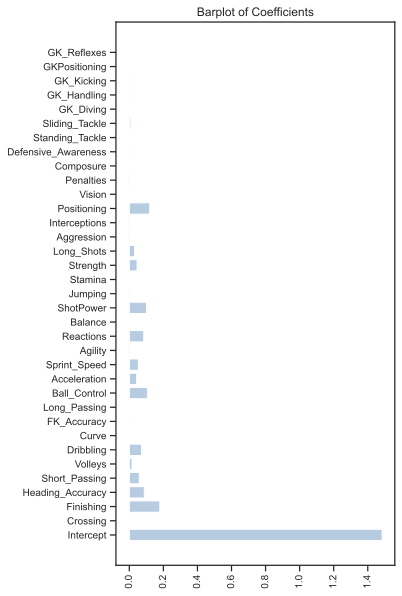

In [28]:
# 绘制系数
plt.figure(figsize=(5,10))
plt.xticks(rotation = 90)
plt.barh(r2.params.index, r2.params,color = '#B8CCE1')
plt.tick_params(labelsize=10)
plt.title('Barplot of Coefficients')

- 如上所示，我们得到了一个非常好的线性回归模型，调整后$R^{2}$达到了0.998，说明我们能比较好的通过球员的能力值预测球员在中锋位置上的评分。  
- 根据上面的柱状图我们可以发现，对于中锋位置的评分加成比较大的因素主要包括终结能力，控球和跑位，这些能力很大程度上决定了一个球员在ST位置上是否会有比较好的发挥。

我们将整个数据集随机划分为80%的训练集和20%的测试集，在训练集上通过线性回归拟合模型，然后到测试集上测试模型效果。

拟合参数:
截距: 1.4634225447257236
回归系数: [-6.69959815e-04  1.78921151e-01  8.80967701e-02  5.86417547e-02
  1.56317274e-02  7.33185737e-02  8.62018504e-04 -7.28181507e-04
  1.85782178e-03  1.04989509e-01  4.21571963e-02  5.38911128e-02
 -3.67759978e-03  8.60198053e-02  1.36673309e-03  1.00355814e-01
 -1.81295905e-03 -6.67429876e-04  4.55474943e-02  3.18265597e-02
 -3.68169326e-03 -3.13797574e-03  1.18479153e-01  1.53963942e-03
 -2.71409240e-03  1.51190634e-03  4.27136477e-03  4.45270674e-03
  6.67936063e-03  1.29789578e-03 -1.11670978e-03  1.06210342e-03
  8.08498335e-04  1.51477176e-04]


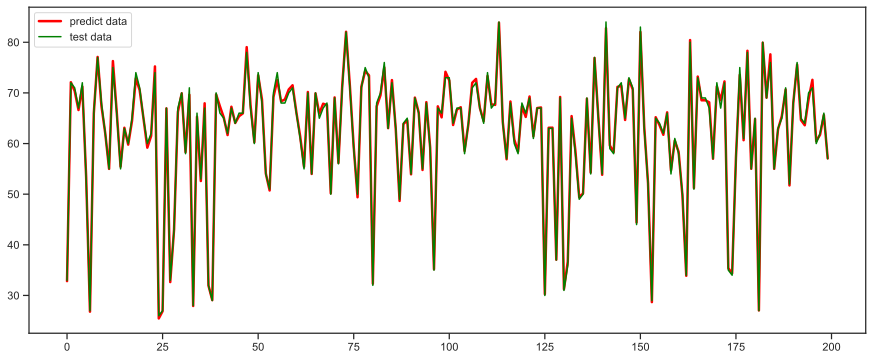

In [29]:
# 选取训练集和测试集
X_train,X_test,Y_train,Y_test=train_test_split(dt_22.iloc[:,49:-2],dt_22['ST'],test_size=0.2,random_state=0)
# 调用线性回归包
model = LinearRegression()
# 线性回归训练
model.fit(X_train, Y_train)  # 调用线性回归包

a = model.intercept_
b = model.coef_
print(u'拟合参数:\n截距:', a)
print(u'回归系数:', b)

# 对测试集数据，用predict函数预测
Y_pred = model.predict(X_test)
plt.figure(figsize=(15,6))
plt.plot(range(len(Y_pred[:200])), Y_pred[:200], 'red', linewidth=2.5, label="predict data")
plt.plot(range(len(Y_test[:200])), Y_test[:200], 'green', label="test data")
plt.legend(loc=2)
plt.show()  # 显示预测值与测试值曲线

取前200个测试集的数据绘图，可以发现我们的模型预测效果也比较好，几乎完美拟合。

### 通过多种分类器预测球员最佳位置并比较效果

下面我将用4种模型，根据球员的各项能力值预测球员在场上的的最佳位置，也就是一个多分类问题。

In [30]:
# 展示X和y
X = dt_22.iloc[:,49:-2]
y = dt_22[['Name','Best Position']]
display('X','y')

,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,...,Penalties,Composure,Defensive Awareness,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GKPositioning,GK Reflexes
0,71.0,95.0,90.0,85.0,89.0,85.0,79.0,85.0,70.0,88.0,...,90.0,88.0,35.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0
1,85.0,91.0,70.0,91.0,88.0,96.0,93.0,93.0,91.0,94.0,...,75.0,96.0,20.0,35.0,24.0,6.0,11.0,15.0,14.0,8.0
2,78.0,93.0,72.0,85.0,83.0,93.0,80.0,69.0,71.0,91.0,...,79.0,88.0,26.0,34.0,32.0,13.0,5.0,7.0,11.0,6.0
3,81.0,93.0,59.0,85.0,84.0,92.0,84.0,69.0,77.0,90.0,...,86.0,92.0,38.0,43.0,41.0,14.0,14.0,9.0,11.0,14.0
4,94.0,83.0,55.0,93.0,83.0,88.0,85.0,83.0,93.0,90.0,...,83.0,89.0,68.0,65.0,53.0,15.0,13.0,5.0,10.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9257,59.0,67.0,62.0,63.0,63.0,65.0,64.0,56.0,52.0,65.0,...,74.0,64.0,33.0,29.0,27.0,9.0,10.0,7.0,7.0,9.0
9258,58.0,33.0,53.0,65.0,24.0,63.0,38.0,30.0,63.0,66.0,...,35.0,68.0,67.0,65.0,62.0,16.0,6.0,6.0,9.0,14.0
9259,65.0,29.0,60.0,68.0,16.0,65.0,64.0,35.0,68.0,66.0,...,40.0,68.0,65.0,71.0,69.0,13.0,12.0,10.0,8.0,14.0
9260,66.0,37.0,47.0,68.0,32.0,62.0,63.0,65.0,71.0,66.0,...,32.0,62.0,64.0,66.0,61.0,14.0,12.0,6.0,11.0,5.0


#### LDA

In [31]:
# 选取训练集和测试集
X = dt_22.iloc[:,49:-2]
y = dt_22['Best Position']
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2,random_state=0)

# 拟合模型
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)

# 训练集预测
pred = model.predict(X_train)
precision_train = sum(pred == Y_train)/len(Y_train)
print('LDA算法训练集预测正确率为：%f'%precision_train)

# 测试集预测
pred = model.predict(X_test)
precision_test = sum(pred == Y_test)/len(Y_test)
print('LDA算法测试集预测正确率为：%f'%precision_test)

LDA算法训练集预测正确率为：0.685424
LDA算法测试集预测正确率为：0.678074


#### 随机森林RF

RF算法训练集预测正确率为：1.000000
RF算法测试集预测正确率为：0.678074


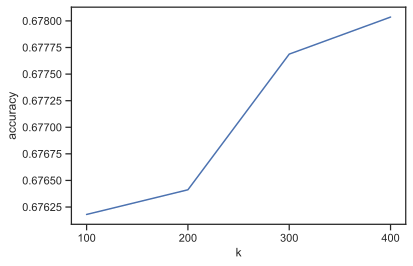

In [32]:
# cross-validation优化超参数k
scores = []
for k in range(100,500,100):
    forest = RandomForestClassifier(n_estimators=k,criterion='gini',random_state=0,n_jobs=2)
    score = cross_val_score(forest, X, y, cv=5, scoring='accuracy')
    scores.append(score.mean())

def k_plot():
    plt.figure()
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.xticks(list(np.linspace(0,500,6)))
    plt.plot(list(range(100,500,100)),scores)
k_plot()

k_opt = 100+np.argmax(scores)*100

forest = RandomForestClassifier(n_estimators=k_opt,criterion='gini',random_state=0,n_jobs=2)
forest.fit(X_train, Y_train)

# 训练集预测
y_train_pred = forest.predict(X_train)
precision_train = sum(y_train_pred == Y_train)/len(Y_train)
print('RF算法训练集预测正确率为：%f'%precision_train)

# 测试集预测
y_test_pred = forest.predict(X_test)
precision_train = sum(y_test_pred == Y_test)/len(Y_test)
print('RF算法测试集预测正确率为：%f'%precision_test)

#### KNN

KNN算法训练集预测正确率为：0.731400
KNN算法测试集预测正确率为：0.686775


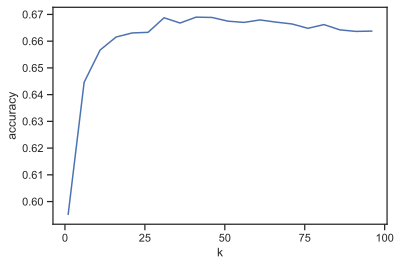

In [33]:
# cross-validation优化超参数k
scores = []
for k in range(1,100,5):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    scores.append(score.mean())

def k_plot():
    plt.figure()
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.xticks(list(np.linspace(0,100,5)))
    plt.plot(list(range(1,100,5)),scores)
k_plot()

k_opt = np.argmax(scores)+1
knn = KNeighborsClassifier(n_neighbors=k_opt)
knn.fit(X_train,Y_train)
precision_train = knn.score(X_train,Y_train)
print('KNN算法训练集预测正确率为：%f'%precision_train)
precision_test = knn.score(X_test,Y_test)
print('KNN算法测试集预测正确率为：%f'%precision_test)

#### SVM

In [34]:
# 将数据二进制化处理
y = label_binarize(y,classes=list(np.unique(y)))
n_classes = y.shape[1]

X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2,random_state=0)

# 设置分类器
clf =SVC(C=0.2,gamma=0.2,kernel='linear', probability=True, random_state=0)
classifier = OneVsRestClassifier(clf,n_jobs=4)
classifier.fit(X_train, Y_train)

# 训练集预测
pred_binary = classifier.predict(X_train)
precision_train = sum([all(pred_binary[i] == Y_train[i]) for i in range(Y_train.shape[0])])/Y_train.shape[0]
print('SVM算法训练集预测正确率为：%f'%precision_train)

# 测试集预测
pred_binary = classifier.predict(X_test)
precision_test = sum([all(pred_binary[i] == Y_test[i]) for i in range(Y_test.shape[0])])/Y_test.shape[0]
print('SVM算法测试集预测正确率为：%f'%precision_test)

SVM算法训练集预测正确率为：0.477302
SVM算法测试集预测正确率为：0.464617


综上，我们可以得到如下结果：

|  分类器   | 训练集正确率  |  测试集正确率  |
| :---- | :---- | :---- |
| LDA  | 69% | 68% |
| RF  | 100% | 68% |
| KNN  | 73% | 69% |
| SVM  | 48% | 46% |

LDA、RF和KNN都实现了一定的分类效果，虽然正确率并不是很高，都在70%左右。SVM模型的效果比较差，我选取的是OvR SVM模型，对这个模型不是很了解，但我觉得应该可以通过调整超参数来进行一些优化。